In [1]:
from DataPreprocessing.python.Data import *

import pandas as pd
import numpy as np


## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# This is new, it will allow us to interact with
# 3d plots in the notebook
from mpl_toolkits.mplot3d import Axes3D


## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

In [2]:
rootData = Data("/Users/czkaiweb/Research/ErdosBootCamp/Project/ProjectData/Root_Insurance_data.csv")
rootData.loadData()
rootData.factorizeData()
rootData.splitData(fraction=[0.5,0.3,0.2],random_seed=42)
data_train = rootData.getTrainDataCopy()
data_validation = rootData.getValidationDataCopy()
data_test  = rootData.getTestDataCopy()

In [3]:
X_train = data_train.iloc[:, 0:4].values
y_train = data_train.iloc[:, -1].values
click_train = data_train.iloc[:, -2].values

X_validation = data_validation.iloc[:, 0:4].values
y_validation = data_validation.iloc[:, -1].values
click_validation = data_validation.iloc[:, -2].values

X_test = data_test.iloc[:, 0:4].values
y_test = data_test.iloc[:, -1].values
click_test = data_test.iloc[:, -2].values

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_validation = sc.transform(X_validation)
X_test = sc.transform(X_test)

In [5]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=5,random_state=42).fit(X_train, y_train)

y_vpred = clf.predict_proba(X_validation)

In [13]:
y_vpred[:,1]

array([0.07904562, 0.07913205, 0.07613216, ..., 0.07742874, 0.07468845,
       0.07913205])

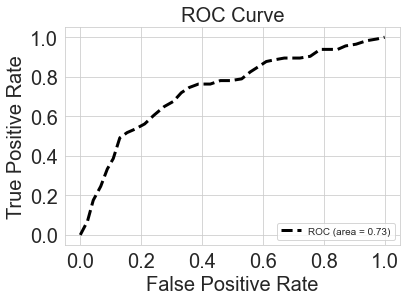

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_validation, y_vpred[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=3)
 
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=20)
plt.ylim([-0.05, 1.05])
plt.yticks(fontsize=20)
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('ROC Curve',fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [22]:
def getReward(regressor, reward, threshold, Xs, ys, clicks):
    total_reward = 0
    for index,X in enumerate(Xs):
        if regressor.predict(X.reshape(1,-1)) > threshold and ys[index] == 1 and clicks[index] == True:
            total_reward += reward
        elif regressor.predict(X.reshape(1,-1)) > threshold and ys[index] == 0 and clicks[index] == True:
            total_reward += -10
    return total_reward

def getROI(reward, threshold, y_preds, ys, clicks):
    stack1 = np.stack([ys, y_preds])
    stack  = np.concatenate((stack1, [clicks]),axis=0)
    stack = stack.T
    
    gain_index = np.logical_and(stack[:,0] == 1,stack[:,1]> threshold)
    gain_stack = stack[gain_index,:]
    gain = len(gain_stack)*reward
    cost_index = np.logical_and(stack[:,2] == True,stack[:,1]> threshold)
    cost_stack = stack[cost_index,:]
    cost = len(cost_stack)*10
    return (gain-cost+len(gain_stack)*10)/(cost+0.001), len(gain_stack), gain-cost+len(gain_stack)*10

In [33]:
reward_list = [1,2,3,4,5,6,7,8,9,10,20,30,40,130]
reward_buffers = {}
nSold_buffers = {}
gain_buffers = {}
thresholds = np.arange(0, 0.1, 0.00001).tolist() +np.arange(0.1, 1.9, 0.8).tolist()

for reward in reward_list:
    reward_buffers[reward]=[]
    nSold_buffers[reward] = []
    gain_buffers[reward] = []
    buffer_reward = []
    buffer_sold = []
    buffer_gain = []
    for threshold in thresholds:
        ROI, nSold, gain = getROI(reward,threshold, y_vpred[:,1], y_validation, click_validation)
        buffer_reward.append(ROI)
        buffer_sold.append(nSold)
        buffer_gain.append(gain)
    reward_buffers[reward]=buffer_reward
    nSold_buffers[reward]=buffer_sold
    gain_buffers[reward]=buffer_gain


<Figure size 432x288 with 0 Axes>

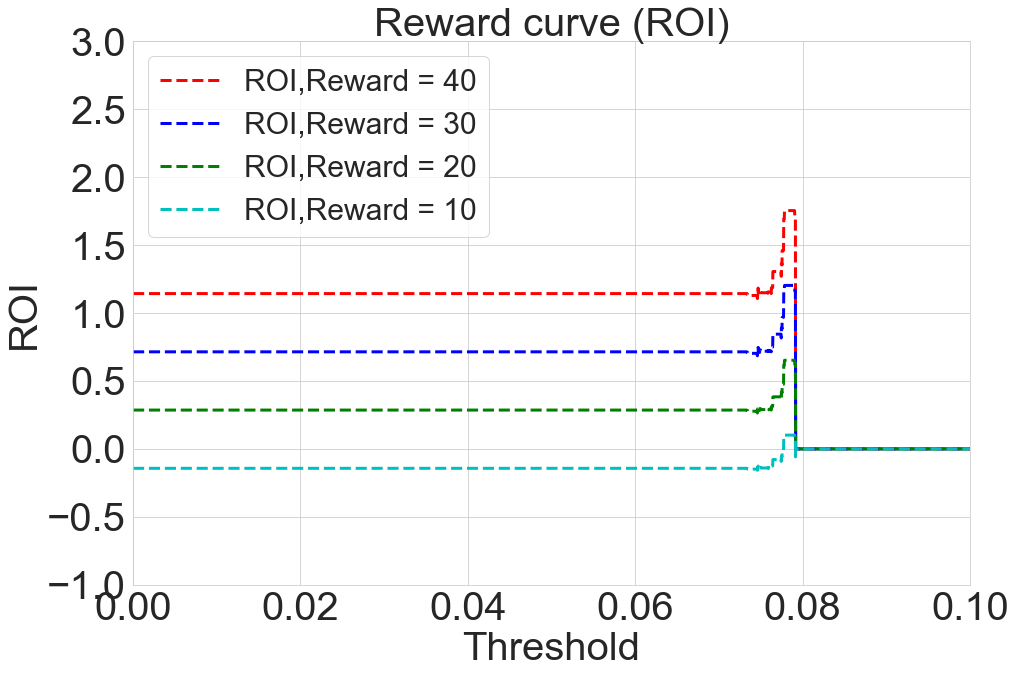

In [34]:
plt.clf()
plt.figure(figsize=(15,10))
plt.plot(thresholds, reward_buffers[40], 'r--',lw=3, label = "ROI,Reward = 40")
plt.plot(thresholds, reward_buffers[30], 'b--',lw=3, label = "ROI,Reward = 30")
plt.plot(thresholds, reward_buffers[20], 'g--',lw=3, label = "ROI,Reward = 20")
plt.plot(thresholds, reward_buffers[10], 'c--',lw=3, label = "ROI,Reward = 10")
 
plt.xlim([-0.0, 0.1])
plt.xticks(fontsize=40)
plt.ylim([-1.0, 3.0])
plt.yticks(fontsize=40)
plt.xlabel('Threshold',fontsize=40)
plt.ylabel('ROI', fontsize=40)
plt.title('Reward curve (ROI)', fontsize=40)
plt.legend(loc="upper left",prop={'size': 30})
plt.show()

<Figure size 432x288 with 0 Axes>

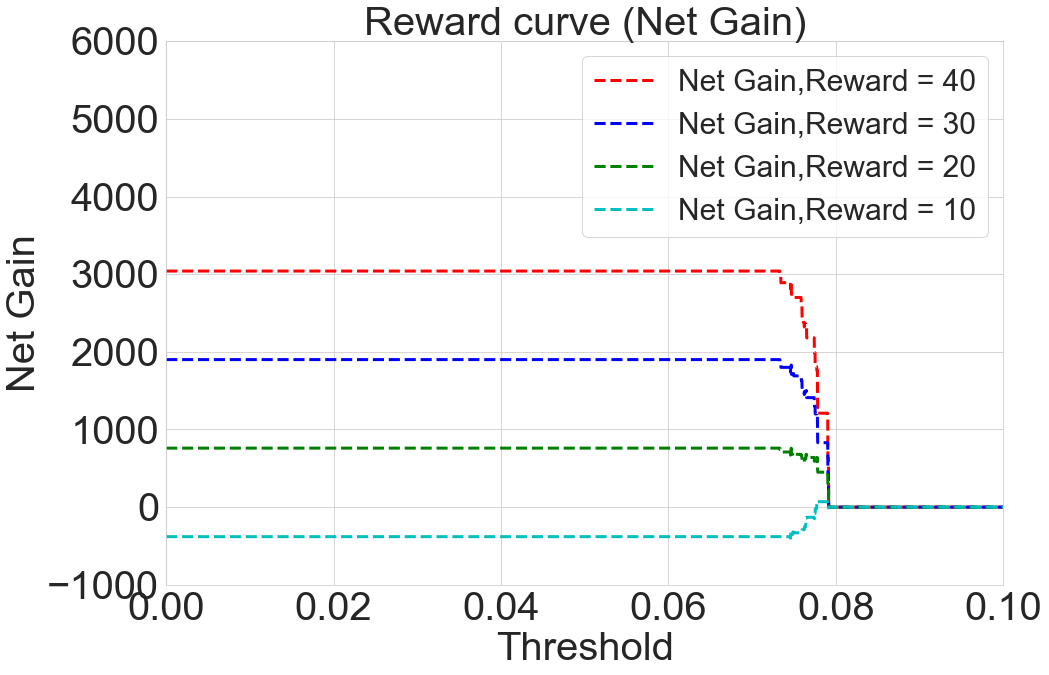

In [39]:
plt.clf()
plt.figure(figsize=(15,10))
plt.plot(thresholds, gain_buffers[40], 'r--',lw=3, label = "Net Gain,Reward = 40")
plt.plot(thresholds, gain_buffers[30], 'b--',lw=3, label = "Net Gain,Reward = 30")
plt.plot(thresholds, gain_buffers[20], 'g--',lw=3, label = "Net Gain,Reward = 20")
plt.plot(thresholds, gain_buffers[10], 'c--',lw=3, label = "Net Gain,Reward = 10")
 
plt.xlim([-0.0, 0.1])
plt.xticks(fontsize=40)
plt.ylim([-1000.0, 6000.0])
plt.yticks(fontsize=40)
plt.xlabel('Threshold',fontsize=40)
plt.ylabel('Net Gain',fontsize=40)
plt.title('Reward curve (Net Gain)',fontsize=40)
plt.legend(loc="upper right",prop={'size': 30})
plt.show()

<Figure size 432x288 with 0 Axes>

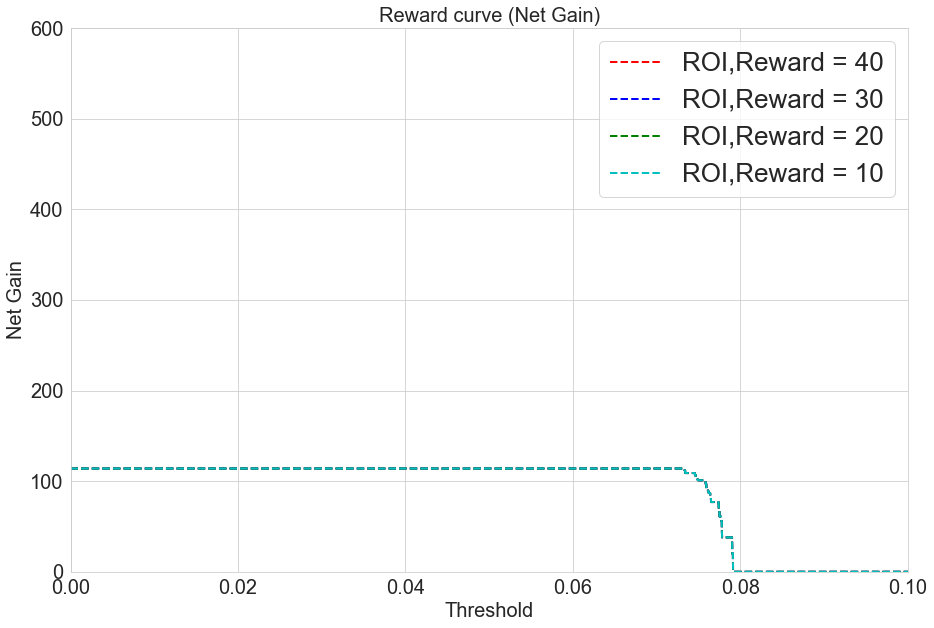

In [38]:
plt.clf()
plt.figure(figsize=(15,10))
plt.plot(thresholds, nSold_buffers[40], 'r--',lw=2, label = "ROI,Reward = 40")
plt.plot(thresholds, nSold_buffers[30], 'b--',lw=2, label = "ROI,Reward = 30")
plt.plot(thresholds, nSold_buffers[20], 'g--',lw=2, label = "ROI,Reward = 20")
plt.plot(thresholds, nSold_buffers[10], 'c--',lw=2, label = "ROI,Reward = 10")
 
plt.xlim([-0.0, 0.1])
plt.xticks(fontsize=20)
plt.ylim([-0.0, 600.0])
plt.yticks(fontsize=20)
plt.xlabel('Threshold',fontsize=20)
plt.ylabel('Net Gain',fontsize=20)
plt.title('Reward curve (Net Gain)',fontsize=20)
plt.legend(loc="upper right",prop={'size': 26})
plt.show()